In [1]:
import time
from tqdm.notebook import trange, tqdm

import numpy as np

from matplotlib import pyplot as plt
import matplotlib

from astropy.table import Table
from astropy.io.votable import parse_single_table, from_table, writeto
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pyvo as vo

%matplotlib inline

In [2]:
ztfobjects = parse_single_table("ztf_CXC_footprint_STAMP.xml").to_table()
skycoords = SkyCoord(ra=ztfobjects['meanra']*u.degree, dec=ztfobjects['meandec']*u.degree, frame='icrs')
# cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')
cone = vo.dal.SCSService('https://cda.cfa.harvard.edu/cxcscs/coneSearch')
maxrad = 50.0 * u.arcmin

csc_results = []

# Start timer
start = time.time()

for i in trange(len(ztfobjects), desc='Indexing'):
    results = cone.search(pos=skycoords[i], radius=maxrad)
    csc_results.append(results)

# End timer
end = time.time()
print(f"Runtime of the program is {end - start}")

csc_res = np.asarray(csc_results, dtype=object)


Runtime of the program is 409.782527923584


In [23]:
ztfobjects['results']=csc_res

f = np.vectorize(len)
ztfobjects['n_res']=f(ztfobjects['results'])

mask = (ztfobjects['n_res'] > 0)
maskedztf = ztfobjects[mask]
# print('Length: %i' % len(maskedztf))
# maskedztf[:5]

zeroobs_mask = (ztfobjects['n_res'] == 0)
zero_ztf = ztfobjects[zeroobs_mask]
writeto(zero_ztf, "ztf_stampobjects_NOarchiveobs.xml")

In [24]:
maskedztf[:2]

oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,g_r_mean_corr,firstmjd,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr,results,n_res
str12,str4,int64,float64,float64,bool,bool,int64,object,object,object,object,float64,float64,float64,float64,float64,object,object,str8,str16,float64,str16,object,int64
ZTF18abiwqjk,10,1759,58316.432106500026,59329.505381899886,True,True,2,None,None,None,None,58435.2652431,59329.505381899886,894.2401387998834,3.2398945,50.35809655,0.00012586500705121358,3.698168465613856e-05,bogus,stamp_classifier,0.38414162,correction_0.0.1,<Table length=1> obsid ra dec ... status public_avail_date deg deg ... object float64 float64 ... object object ------ ----------------- ----------------- ... -------- ------------------- 1864 3.072916666666667 50.43136111111111 ... archived 2002-01-09T00:00:00,1
ZTF18abiagdn,4,1770,58317.3802894,59329.505381899886,True,True,2,None,None,None,None,58435.2652431,59329.505381899886,894.2401387998834,3.23719265,50.10339005,0.0004404568140012446,0.00024515392103841997,bogus,stamp_classifier,0.6067099,correction_0.0.1,<Table length=1> obsid ra dec ... status public_avail_date deg deg ... object float64 float64 ... object object ------ ----------------- ----------------- ... -------- ------------------- 1864 3.072916666666667 50.43136111111111 ... archived 2002-01-09T00:00:00,1


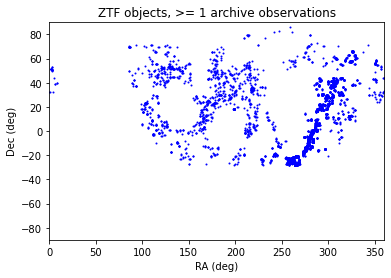

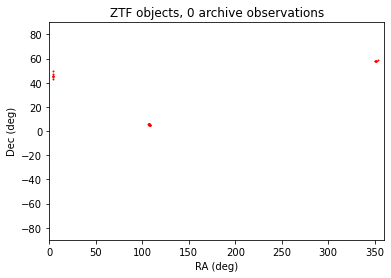

In [25]:
plt.plot(maskedztf['meanra'], maskedztf['meandec'], 'o', ms=1, color='blue')
plt.title("ZTF objects, >= 1 archive observations")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.xlim([0, 360])
plt.ylim([-90, 90])
plt.savefig('observed_ZTF_objects.pdf')
plt.show()

plt.plot(zero_ztf['meanra'], zero_ztf['meandec'], 'o', ms=1, color='red')
plt.title("ZTF objects, 0 archive observations")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.xlim([0, 360])
plt.ylim([-90, 90])
plt.savefig('NOTobserved_ZTF_objects.pdf')
plt.show()

In [26]:
rztf = maskedztf['results'].data
obsids = np.asarray([t['obsid'].data.astype(str) for t in rztf], dtype=object)
of = np.hstack(obsids)
tof = tuple(of)
# tof

In [27]:
tapservice = vo.dal.TAPService("https://cda.cfa.harvard.edu/cxctap/")
query = '''
SELECT o.obs_id, o.obs_creation_date, o.s_ra, o.s_dec, o.s_region
FROM ivoa.ObsCore AS o
WHERE o.dataproduct_type = 'event' AND o.obs_id IN {}
'''.format(tof)

# Start timer
start = time.time()

tapresult = tapservice.search(query)

# End timer
end = time.time()
print(f"Runtime of the program is {end - start}")

tresult = tapresult.to_table()
tresult['obs_creation_date'] = Time(tresult['obs_creation_date'].astype(str), format='isot', scale='utc').mjd
tresult['obs_id'] = tresult['obs_id'].astype(str)

Runtime of the program is 137.0635907649994


In [ ]:
# Testing to see if this works...
# a = obsids[4]
# print(a)
# print(np.count_nonzero(np.in1d(tresult['obs_id'], a) == True))
# tresult[np.in1d(tresult['obs_id'], a)]

In [28]:
footprints = np.asarray([tresult[np.in1d(tresult['obs_id'], a)] for a in obsids], dtype=object)
maskedztf['footprints'] = footprints

In [29]:
maskedztf[:2]

oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,g_r_mean_corr,firstmjd,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr,results,n_res,footprints
str12,str4,int64,float64,float64,bool,bool,int64,object,object,object,object,float64,float64,float64,float64,float64,object,object,str8,str16,float64,str16,object,int64,object
ZTF18abiwqjk,10,1759,58316.432106500026,59329.505381899886,True,True,2,None,None,None,None,58435.2652431,59329.505381899886,894.2401387998834,3.2398945,50.35809655,0.00012586500705121358,3.698168465613856e-05,bogus,stamp_classifier,0.38414162,correction_0.0.1,<Table length=1> obsid ra dec ... status public_avail_date deg deg ... object float64 float64 ... object object ------ ----------------- ----------------- ... -------- ------------------- 1864 3.072916666666667 50.43136111111111 ... archived 2002-01-09T00:00:00,1,obs_id ... ... ------ ... 1864 ...
ZTF18abiagdn,4,1770,58317.3802894,59329.505381899886,True,True,2,None,None,None,None,58435.2652431,59329.505381899886,894.2401387998834,3.23719265,50.10339005,0.0004404568140012446,0.00024515392103841997,bogus,stamp_classifier,0.6067099,correction_0.0.1,<Table length=1> obsid ra dec ... status public_avail_date deg deg ... object float64 float64 ... object object ------ ----------------- ----------------- ... -------- ------------------- 1864 3.072916666666667 50.43136111111111 ... archived 2002-01-09T00:00:00,1,obs_id ... ... ------ ... 1864 ...


In [30]:
filename = 'ztf_archive-obs_STAMP'
writeto(maskedztf, filename)